# Summer Project

# Topic - Object Identification using Deep Learning Tensorflow Framework

* We used Tensorflow as backend using `keras` API.

# CNN architecture to identify dog's breed

We are trying to build a CNN architecture (using keras library which uses tensorflow as backend) which will classify the breed of the dog from any supplied images from an user. 

The task of assigning breed to a dog from images is exceptionally chalenging as more than one breed looks just like another.

Few examples:

![Imgur](https://i.imgur.com/hsnUipH.png)

![Imgur](https://i.imgur.com/L7EdyY5.png)

![Imgur](https://i.imgur.com/TGA4LQD.png)

## Step 1 - Import Dataset

In the following code below we are importing the dataset. We will populate our dataset using flip and some other cropping techniques.

In [38]:
import tensorflow as tf

tf.__version__

'1.6.0'

In [2]:
from sklearn.datasets import load_files
from keras.utils import np_utils
import numpy as np
from glob import glob

Using TensorFlow backend.


### Function to load train, test and validate dataset

In [3]:
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

In [4]:
#Load train, test and validation dataset

train_files, train_targets = load_dataset('dogImages/train')
valid_files, valid_targets = load_dataset('dogImages/valid')
test_files, test_targets = load_dataset('dogImages/test')

#Load list of dog names
dog_names = [item[20:-1] for item in sorted(glob('dogImages/train/*/'))]

#Print different statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %d total dog images.' % len(np.hstack([train_files, valid_files, test_files])))

print('There are %d total training images of dogs.' % len(train_files))
print('There are %d total validation images of dogs.' % len(valid_files))
print('There are %d total test images of dogs.' % len(test_files))

There are 133 total dog categories.
There are 8351 total dog images.
There are 6680 total training images of dogs.
There are 835 total validation images of dogs.
There are 836 total test images of dogs.


## Step 2 - Detect Dogs

We are using pre-trained [ResNet-50](http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006) model to detect the dogs in the images.

Our first line of code downloads the ResNet-50 model, along with the weights that have been trained on [ImageNet](image-net.org) a very large and popular dataset used for computer vision and image classification tasks.

In [5]:
from keras.applications.resnet50 import ResNet50
import h5py

#defining the model
ResNet50_model = ResNet50(weights='imagenet')

### Data Preprocessing

When using TensorFlow as backend, Keras CNNs require a 4D array (which we'll also refer to as a 4D tensor) as input, with shape

                                    $(nb_samples, rows, columns, channels)$

where `nb_samples` corresponds to the total number of images (or samples), and rows, columns, and channels correspond to the number of rows, columns, and channels for each image, respectively.

The `path_to_tensor` function below takes a string-valued file path to a color image as input and returns a 4D tensor suitable for supplying to a Keras CNN. The function first loads the image and resizes it to a square image that is 
$224 \times 224$ pixels. 

Next, the image is converted to an array, which is then resized to a 4D tensor. In this case, since we are working with color images, each image has three channels. Likewise, since we are processing a single image (or sample), the returned tensor will always have shape

                                                $(1, 224, 224, 3)$
                                                
The `paths_to_tensor` function takes a numpy array of string-valued image paths as input and returns a 4D tensor with shape  

                                            $(nb_samples, 224, 224, 3)$

Here, `nb_samples` is the number of samples, or number of images, in the supplied array of image paths. It is best to think of nb_samples as the number of 3D tensors (where each 3D tensor corresponds to a different image) in your dataset!

In [6]:
from keras.preprocessing import image
from tqdm import tqdm

def path_to_tensor(img_path):
    
    #load RGB image as PIL.image.image type
    img = image.load_img(img_path, target_size=(224, 224))
    
    #convert PIL.image.image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis = 0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

### Making Predictions with ResNet-50

Getting the 4D tensor ready for ResNet-50, and for any other pre-trained model in Keras, requires some additional processing:
* First, the RGB image is converted to BGR by reordering the channels.
* All pre-trained models have the additional normalization step that the mean pixel (expressed in RGB as $[103.939, 116.779, 123.68]$ and calculated from all     pixels in all images in ImageNet) must be subtracted from every pixel in each image.
* This is implemented in the imported function `preprocess_input`.

Now that we have a way to format our image for supplying to `ResNet-50`, we are now ready to use the model to extract the predictions. 
This is accomplished with the predict method, which returns an array whose $i$-th entry is the model's predicted probability that the image belongs to the $i$-th ImageNet category. This is implemented in the ResNet50_predict_labels function below.

By taking the argmax of the predicted probability vector, we obtain an integer corresponding to the model's predicted object class, which we can identify with an object category through the use of this [dictionary](https://github.com/keras-team/keras/blob/master/keras/applications/imagenet_utils.py).

In [7]:
from keras.applications.resnet50 import preprocess_input, decode_predictions

def ResNet50_predict_labels(img_path):
    
    #return prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

### Write a dog detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from 'Chihuahua' to 'Mexican hairless'. Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained ResNet-50 model, we need only check if the ResNet50_predict_labels function above returns a value between 151 and 268 (inclusive).

In [8]:
# returns "True" if a dog is detected in the image stored at img_path### retu 
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151))

### Test the dog detector


In [9]:
dog_files_short = train_files[:100]
dog_count = 0
for img in dog_files_short:
    isDog = dog_detector(img)
    if isDog:
        dog_count += 1
    percentage = (dog_count/len(dog_files_short)) * 100
print('Percentage of dogs correctly classified as dogs: {}%'.format(percentage))

Percentage of dogs correctly classified as dogs: 100.0%


## Step 3 - Create a CNN to classify dog breeds

**Convolutional Architecture** -


### Pre process the data

We rescale the data by dividing every pixel in every image by 255.

In [11]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|██████████| 836/836 [00:14<00:00, 59.49it/s]


### Image Augmentation


In [12]:
from keras.preprocessing.image import ImageDataGenerator

# create and configure augmented image generator
datagen = ImageDataGenerator(
    
    width_shift_range=0.1,   # randomly shift images horizontally (10% of total width)
    height_shift_range=0.1,  # randomly shift images vertically (10% of total height)
    horizontal_flip=True)    # randomly flip images horizontally

# fit augmented image generator on data
datagen.fit(train_tensors)

### Defining CNN architecture

In [13]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense, Activation
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization

model = Sequential()

# Layer 1
model.add(BatchNormalization(input_shape=(224, 224, 3)))
model.add(Conv2D(filters=16, kernel_size=3, kernel_initializer='he_normal', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization())

# Layer 2
model.add(Conv2D(filters=32, kernel_size=3, kernel_initializer='he_normal', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization())

# Layer 3
model.add(Conv2D(filters=64, kernel_size=3, kernel_initializer='he_normal', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization())

# Layer 4
model.add(Conv2D(filters=128, kernel_size=3, kernel_initializer='he_normal', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization())

# Layer 5
model.add(Conv2D(filters=256, kernel_size=3, kernel_initializer='he_normal', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization())

model.add(GlobalAveragePooling2D())

model.add(Dense(133, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, 224, 224, 3)       12        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 222, 222, 16)      448       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 111, 111, 16)      0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 111, 111, 16)      64        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 109, 109, 32)      4640      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 54, 54, 32)        128       
__________

### Compiling the model

In [14]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

### Training time

In [17]:
from keras.callbacks import ModelCheckpoint

epochs = 25
batch_size = 20

checkpointer = ModelCheckpoint(filepath='saved_models/weights.bestaugmented.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

# Using Image Augmentation
model.fit_generator(datagen.flow(train_tensors, train_targets, batch_size=batch_size),
                    validation_data = (valid_tensors, valid_targets), 
                    steps_per_epoch = train_tensors.shape[0] // batch_size,
                    epochs = epochs, callbacks = [checkpointer], verbose = 1)

Epoch 1/25
334/334 [==============================] - 590s 2s/step - loss: 4.0641 - acc: 0.0895 - val_loss: 4.0589 - val_acc: 0.0802

Epoch 00001: val_loss improved from inf to 4.05890, saving model to saved_models/weights.bestaugmented.from_scratch.hdf5
Epoch 2/25
334/334 [==============================] - 610s 2s/step - loss: 3.7496 - acc: 0.1296 - val_loss: 3.8358 - val_acc: 0.1246

Epoch 00002: val_loss improved from 4.05890 to 3.83580, saving model to saved_models/weights.bestaugmented.from_scratch.hdf5
Epoch 3/25
334/334 [==============================] - 601s 2s/step - loss: 3.4510 - acc: 0.1850 - val_loss: 3.6580 - val_acc: 0.1521

Epoch 00003: val_loss improved from 3.83580 to 3.65801, saving model to saved_models/weights.bestaugmented.from_scratch.hdf5
Epoch 4/25
334/334 [==============================] - 591s 2s/step - loss: 3.1828 - acc: 0.2265 - val_loss: 3.3740 - val_acc: 0.1701

Epoch 00004: val_loss improved from 3.65801 to 3.37396, saving model to saved_models/weights.

In [69]:
# To save the weights

fname = "weights-Test-CNN-5-Layer-model.hdf5"
model.save_weights(fname, overwrite=True)

### Load the model with best validation accuracy

In [68]:
model.load_weights('saved_models/weights.bestaugmented.from_scratch.hdf5')

### Test the model and check the test accuracy

In [18]:
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 49.4019%


## Step 4 - Create a CNN model to improve the accuracy using Transfer Learning

We will use bottleneck features and then we will train our model using **ResNet-50** architecture for better results 

### Obtain bottleneck features

In the code block below, I extract the bottleneck features corresponding to the train, test, and validation sets.

In [19]:
#Obtain bottleneck features from another pre-trained CNN.

bottleneck_features = np.load('bottleneck_features/DogResnet50Data.npz')
train_ResNet50 = bottleneck_features['train']
valid_ResNet50 = bottleneck_features['valid']
test_ResNet50 = bottleneck_features['test']

### ResNet Model architecture

In [20]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense, Activation
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization

ResNet_model = Sequential()
ResNet_model.add(GlobalAveragePooling2D(input_shape=train_ResNet50.shape[1:]))
ResNet_model.add(Dense(133, activation='softmax'))

ResNet_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 133)               272517    
Total params: 272,517
Trainable params: 272,517
Non-trainable params: 0
_________________________________________________________________


### Compile the model

In [21]:
from keras.optimizers import Adam, Adamax

ResNet_model.compile(loss = 'categorical_crossentropy', optimizer = Adamax(lr = 0.002), metrics = ['accuracy'])

### Training time 2.0 

In [22]:
from keras.callbacks import ModelCheckpoint  

checkpointer = ModelCheckpoint(filepath = 'saved_models/weights.best_adamax.ResNet50.hdf5', 
                               verbose = 1, save_best_only = True)

epochs = 30
batch_size = 64

ResNet_model.fit(train_ResNet50, train_targets, 
          validation_data = (valid_ResNet50, valid_targets),
          epochs = epochs, batch_size = batch_size, callbacks = [checkpointer], verbose = 1)

Train on 6680 samples, validate on 835 samples
Epoch 1/30
6680/6680 [==============================] - 2s 313us/step - loss: 2.3131 - acc: 0.5028 - val_loss: 1.2258 - val_acc: 0.6946

Epoch 00001: val_loss improved from inf to 1.22578, saving model to saved_models/weights.best_adamax.ResNet50.hdf5
Epoch 2/30
6680/6680 [==============================] - 1s 164us/step - loss: 0.7597 - acc: 0.8439 - val_loss: 0.9049 - val_acc: 0.7605

Epoch 00002: val_loss improved from 1.22578 to 0.90488, saving model to saved_models/weights.best_adamax.ResNet50.hdf5
Epoch 3/30
6680/6680 [==============================] - 1s 153us/step - loss: 0.5108 - acc: 0.9024 - val_loss: 0.7676 - val_acc: 0.7916

Epoch 00003: val_loss improved from 0.90488 to 0.76763, saving model to saved_models/weights.best_adamax.ResNet50.hdf5
Epoch 4/30
6680/6680 [==============================] - 1s 159us/step - loss: 0.3703 - acc: 0.9401 - val_loss: 0.7130 - val_acc: 0.7952

Epoch 00004: val_loss improved from 0.76763 to 0.712

In [70]:
# To save the weights

fname = "weights-Test-CNN-ResNet-Layer-model.hdf5"
ResNet_model.save_weights(fname, overwrite=True)

### Load the model with best validation loss

In [23]:
ResNet_model.load_weights('saved_models/weights.best_adamax.ResNet50.hdf5')

### Test the model accuracy

In [64]:
#get index of predicted dog breed for each image in test set
ResNet50_predictions = [np.argmax(ResNet_model.predict(np.expand_dims(feature, axis=0))) for feature in test_ResNet50]

#report test accuracy
test_accuracy = 100*np.sum(np.array(ResNet50_predictions)==np.argmax(test_targets, axis=1))/len(ResNet50_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 84.0909%


### More training

In [71]:
epochs = 30
batch_size = 64

ResNet_model.fit(train_ResNet50, train_targets, 
          validation_data = (valid_ResNet50, valid_targets),
          epochs = epochs, batch_size = batch_size, callbacks = [checkpointer], verbose = 1)

Train on 6680 samples, validate on 835 samples
Epoch 1/30
6680/6680 [==============================] - 4s 554us/step - loss: 0.0357 - acc: 0.9990 - val_loss: 0.5540 - val_acc: 0.8371

Epoch 00001: val_loss did not improve
Epoch 2/30
6680/6680 [==============================] - 2s 326us/step - loss: 0.0260 - acc: 0.9985 - val_loss: 0.5522 - val_acc: 0.8359

Epoch 00002: val_loss did not improve
Epoch 3/30
6680/6680 [==============================] - 2s 319us/step - loss: 0.0217 - acc: 0.9987 - val_loss: 0.5409 - val_acc: 0.8479

Epoch 00003: val_loss did not improve
Epoch 4/30
6680/6680 [==============================] - 2s 317us/step - loss: 0.0182 - acc: 0.9990 - val_loss: 0.5411 - val_acc: 0.8383

Epoch 00004: val_loss did not improve
Epoch 5/30
6680/6680 [==============================] - 2s 312us/step - loss: 0.0156 - acc: 0.9988 - val_loss: 0.5507 - val_acc: 0.8299

Epoch 00005: val_loss did not improve
Epoch 6/30
6680/6680 [==============================] - 2s 312us/step - loss: 

### More Training

In [72]:
epochs = 40
batch_size = 64

ResNet_model.fit(train_ResNet50, train_targets, 
          validation_data = (valid_ResNet50, valid_targets),
          epochs = epochs, batch_size = batch_size, callbacks = [checkpointer], verbose = 1)

Train on 6680 samples, validate on 835 samples
Epoch 1/40
6680/6680 [==============================] - 2s 313us/step - loss: 0.0028 - acc: 0.9991 - val_loss: 0.6259 - val_acc: 0.8491

Epoch 00001: val_loss did not improve
Epoch 2/40
6680/6680 [==============================] - 2s 308us/step - loss: 0.0032 - acc: 0.9987 - val_loss: 0.6254 - val_acc: 0.8467

Epoch 00002: val_loss did not improve
Epoch 3/40
6680/6680 [==============================] - 2s 310us/step - loss: 0.0028 - acc: 0.9988 - val_loss: 0.6230 - val_acc: 0.8491

Epoch 00003: val_loss did not improve
Epoch 4/40
6680/6680 [==============================] - 2s 304us/step - loss: 0.0025 - acc: 0.9991 - val_loss: 0.6431 - val_acc: 0.8383

Epoch 00004: val_loss did not improve
Epoch 5/40
6680/6680 [==============================] - 2s 314us/step - loss: 0.0027 - acc: 0.9991 - val_loss: 0.6286 - val_acc: 0.8527

Epoch 00005: val_loss did not improve
Epoch 6/40
6680/6680 [==============================] - 2s 319us/step - loss: 

### More training 

Increasing the learning rate from `lr=0.002` to `lr=0.001`

In [73]:
opt = Adamax(lr=0.001)
epochs = 10
batch_size = 64

ResNet_model.fit(train_ResNet50, train_targets, 
          validation_data=(valid_ResNet50, valid_targets),
          epochs=epochs, batch_size=batch_size, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/10
6680/6680 [==============================] - 43s 6ms/step - loss: 0.0018 - acc: 0.9993 - val_loss: 0.8028 - val_acc: 0.8443

Epoch 00001: val_loss did not improve
Epoch 2/10
6680/6680 [==============================] - 2s 271us/step - loss: 0.0017 - acc: 0.9990 - val_loss: 0.7863 - val_acc: 0.8467

Epoch 00002: val_loss did not improve
Epoch 3/10
6680/6680 [==============================] - 2s 282us/step - loss: 0.0020 - acc: 0.9993 - val_loss: 0.7983 - val_acc: 0.8455

Epoch 00003: val_loss did not improve
Epoch 4/10
6680/6680 [==============================] - 2s 291us/step - loss: 0.0022 - acc: 0.9988 - val_loss: 0.8003 - val_acc: 0.8407

Epoch 00004: val_loss did not improve
Epoch 5/10
6680/6680 [==============================] - 2s 281us/step - loss: 0.0021 - acc: 0.9990 - val_loss: 0.8038 - val_acc: 0.8455

Epoch 00005: val_loss did not improve
Epoch 6/10
6680/6680 [==============================] - 2s 291us/step - loss: 0

## Predict the dog breed using this model

In [29]:
def extract_Resnet50(tensor):
    from keras.applications.resnet50 import ResNet50, preprocess_input
    return ResNet50(weights='imagenet', include_top=False).predict(preprocess_input(tensor))

In [51]:
#To show the images
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

#This function takes a path as input image and return the breed of the dog.
def ResNet50_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_Resnet50(path_to_tensor(img_path))
    
    # obtain predicted vector
    predicted_vector = ResNet_model.predict(bottleneck_feature)
    
    # return dog breed that is predicted by the model
    breed = dog_names[np.argmax(predicted_vector)]
    image = mpimg.imread(img_path)
    imgplot = plt.imshow(image)
    
    if dog_detector(img_path) == True:
        return print("The breed of dog is a {}".format(breed))

In [52]:
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151))

In [53]:
def predict_breed(img_path):
    isDog = dog_detector(img_path)
    if isDog:
        print("Detected a dog.\n")
        breed = ResNet50_predict_breed(img_path)
        return breed
    else:
        print('No dog picture found.')

# Testing our result

Detected a dog.

The breed of dog is a Beagle


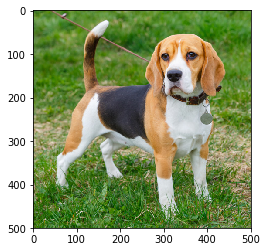

In [54]:
predict_breed('testImages/beagle.jpg')

Detected a dog.

The breed of dog is a Afghan_hound


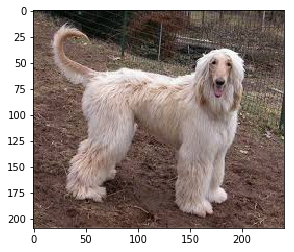

In [55]:
predict_breed('testImages/afghan_hound.jpeg')

Detected a dog.

The breed of dog is a Belgian_malinois


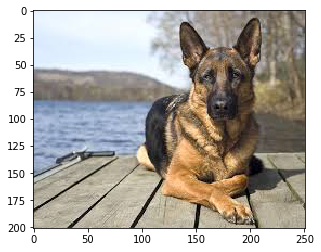

In [56]:
predict_breed('testImages/german_shepherd.jpeg')

#### Here we can see the first error made by our model..

___

Detected a dog.

The breed of dog is a Labrador_retriever


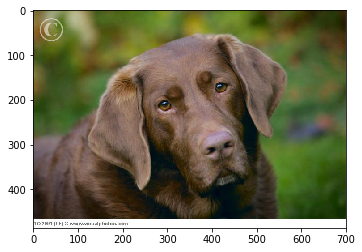

In [57]:
predict_breed('testImages/Labrador_retriever.jpg')

Detected a dog.

The breed of dog is a American_water_spaniel


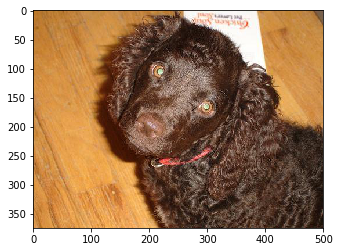

In [58]:
predict_breed('testImages/American_water_spaniel.jpg')

Detected a dog.

The breed of dog is a German_shepherd_dog


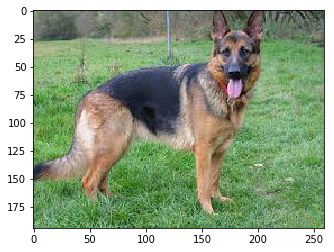

In [59]:
predict_breed('testImages/german_shepherd2.jpeg')

Detected a dog.

The breed of dog is a Chihuahua


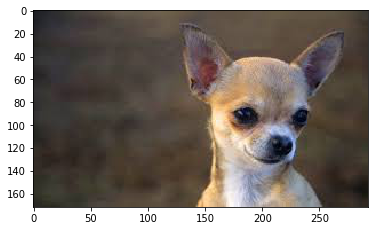

In [60]:
predict_breed('testImages/chihuahua.jpeg')

Detected a dog.

The breed of dog is a Saint_bernard


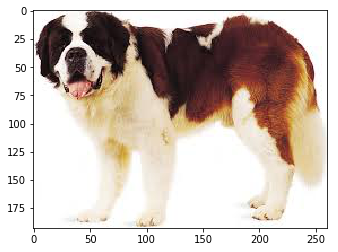

In [61]:
predict_breed('testImages/saint_bernard.jpeg')

In [63]:
predict_breed('testImages/test.png')

No dog picture found.


Detected a dog.

The breed of dog is a Brittany


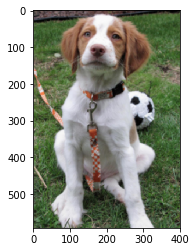

In [65]:
predict_breed('testImages/Brittany.png')

Detected a dog.

The breed of dog is a Chow_chow


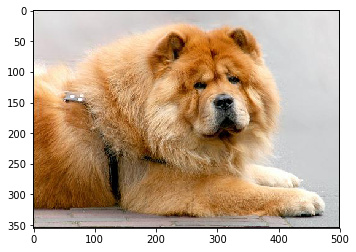

In [66]:
predict_breed('testImages/Chow_chow.jpg')

In [67]:
predict_breed('testImages/test.png')

No dog picture found.


In [74]:
predict_breed('testImages/trump.jpeg')

No dog picture found.


In [79]:
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
plot_model(model)

ModuleNotFoundError: No module named 'pydot'